In [1]:
%load_ext autoreload
%autoreload 2

from DarkMatter import *

Welcome to JupyROOT 6.26/08


In [260]:
import numpy as np
from scipy.optimize import minimize

def cash_stat(params, on_count, off_count, signal_count, alpha):
    """
    Calculate Cash statistic (modified for profile likelihood)
    """
    signal_scale, background_scale = params
    signal_scale = 10**signal_scale
    
    model_on = signal_scale * signal_count + background_scale * off_count * alpha
    model_off = background_scale * off_count
    
    # Cash statistic (Poisson likelihood function)
    cash_on = model_on + on_count * np.log((on_count+1e-10) / (model_on+1e-10))
    cash_off = model_off + off_count * np.log((off_count+1e-10) / (model_off+1e-10))
    
    return cash_on + cash_off

def sum_cash_stat(params, on_counts, off_counts, signal_counts, alpha):
    """Sum Cash statistics across all bins"""
    total_cash = 0
    for on, off, signal in zip(on_counts, off_counts, signal_counts):
        total_cash += cash_stat(params, on, off, signal, alpha)
    return total_cash

def fit_on_off_data(on_counts, off_counts, signal_counts, alpha):
    """Fit data using Cash statistic minimization"""
    initial_params = [-1, 1.0]
    bounds = [(-5, 5), (0.8, 1.2)]
    
    # Minimize negative log-likelihood
    result = minimize(sum_cash_stat, initial_params, 
                     args=(on_counts, off_counts, signal_counts, alpha),
                     method='L-BFGS-B', bounds=bounds)
    
    return result.x, result.fun

def bin_by_bin_log_likelihood(signal_scales, on_count, off_count, signal_count, alpha, params):
    """
    Calculate profile likelihood for different signal scales
    Returns: Delta log-likelihood relative to best fit
    """
    background_scale = params[1]
    loglikelihood_profile = []
    for scale in signal_scales:
        # For each signal scale, optimize background
        current_params = [scale, background_scale]
        # Calculate log-likelihood
        ll = -cash_stat(current_params, on_count, off_count, signal_count, alpha)
        # Store delta log-likelihood
        loglikelihood_profile.append((ll))

        
    subtracted = max(loglikelihood_profile)-loglikelihood_profile
    aboveMax = (subtracted>min(subtracted))
    st_idx = list(aboveMax).index(False)
    intp = interp1d(subtracted[st_idx:], signal_scales[st_idx:])
    
    return subtracted, intp(1.35)


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_likelihood_energy(ll_array, energy_flux):
    """
    Plot energy flux upper limits aligned with likelihood profiles
    
    Parameters:
    -----------
    ll_array : dict
        Dictionary with energy as key and array of [flux, likelihood] as values
    energy_flux : array-like
        Energy flux upper limit values
    energies : array-like
        Energy values
    """
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Create mesh grid for likelihood plot
    likelihood_mesh = []
    flux_values = []
    
    # Extract first energy bin's flux values to determine the common flux grid
    first_energy = list(ll_array.keys())[0]
    n_flux_points = len(ll_array[first_energy])
    energies = np.array(list(ll_array.keys()))
    
    # Collect likelihood profiles and flux values
    for energy in energies:
        if energy in ll_array:
            data = ll_array[energy]
            flux_values = data[:, 0]  # Flux values
            likelihood_mesh.append(data[:, 1])  # Likelihood values
    
    likelihood_mesh = np.array(likelihood_mesh).T
    # Mask likelihood values above 10
    masked_likelihood = np.ma.masked_where(likelihood_mesh > 10, likelihood_mesh)
    
    # Plot likelihood profiles

    im = ax1.pcolormesh(energies, flux_values, masked_likelihood,
                        shading='auto', cmap='turbo',
                        norm=mcolors.Normalize(vmin=0, vmax=10))

    # Plot upper limits with arrows

    log_energies = np.log10(energies)
    bin_width = log_energies[1] - log_energies[0]  # Width in log space
    xerr = np.array([energies * (1 - 10**(-bin_width/2)), 
                     energies * (10**(bin_width/2) - 1)])
    
    # Plot upper limits with errorbars
    ax1.errorbar(energies, energy_flux, 
                xerr=xerr,
                yerr=0.2 * energy_flux,  # 20% error bar length
                uplims=True,
                fmt='k.',
                markersize=8,
                capsize=3,
                label='95% C.L. Upper Limits')
    
    # Set axes scales and limits
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    
    # Labels and formatting
    ax1.set_ylabel(r'Flux (GeV/cm$^2$/s)', fontsize=12)
    ax1.set_xlabel('Energy (GeV)')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax1)
    cbar.set_label('Δ log L', fontsize=12)
        
    ax1.set_ylim(1e-11, 1e-7)
    ax1.set_xlim(min(energies)*0.9, max(energies)*1.1)
    return ax1

In [249]:
for dwarf in const.ListOfDwarf:
    On, Off = EventDisplay.readData(dwarf, ext=True, apply_weight=False)
    rawData = EventDisplay.readData(dwarf, ext=True, rawdata=True)
    irf = ResponseFunction.EventDisplay.readIRFs(dwarf, ext=True)
    Signal = combinedCalcSignal(dwarf, 1e4, DM_spectra="powerlaw", irf=irf, ext=True, eLowerCut=min(rawData[:,0]))
    combined_pars, loglikelihood = fit_on_off_data(getArray(On)[1], getArray(Off)[1], getArray(Signal)[1], alpha=1/6.)

    ll_array = {}
    best_norms = []
    energies = []
    ll_array_plot = []
    for i, eng in enumerate(getArray(Off)[0]):
        try:
            ll, norm = bin_by_bin_log_likelihood(np.linspace(-3, 3, 100), 
                                                   getArray(On)[1][i], 
                                                   getArray(Off)[1][i], 
                                                   getArray(Signal)[1][i], 
                                                   1/6., combined_pars)
        except:
            continue
        ll_array[eng] = np.asarray([eng**2*(eng/1e3)**-2*1e-23*1e7*10**np.linspace(-3, 3, 100), ll]).T

        best_norms.append(norm)
        energies.append(eng)

    best_norms = np.asarray(best_norms)
    energies = np.asarray(energies)
    
    energyflux = []
    for energy, par in zip(getArray(Signal)[0], best_norms):
        energyflux.append(energy**2*(energy/1e3)**-2*1e-23*1e7*10**par)
    energyflux = np.asarray(energyflux)

    np.save(f"{dwarf}_energy_flux", np.asarray([energies, energyflux]).T)
    np.save(f"{dwarf}_likelihood", ll_array)

In [250]:
dwarf = "UMa_II"

In [262]:
On, Off = EventDisplay.readData(dwarf, ext=True, apply_weight=False)
rawData = EventDisplay.readData(dwarf, ext=True, rawdata=True)
irf = ResponseFunction.EventDisplay.readIRFs(dwarf, ext=True)
Signal = combinedCalcSignal(dwarf, 1e4, DM_spectra="powerlaw", irf=irf, ext=True, eLowerCut=min(rawData[:,0]))
combined_pars, loglikelihood = fit_on_off_data(getArray(On)[1], getArray(Off)[1], getArray(Signal)[1], alpha=1/6.)

ll_array = {}
best_norms = []
energies = []
ll_array_plot = []
for i, eng in enumerate(getArray(Off)[0]):
    try:
        ll, norm = bin_by_bin_log_likelihood(np.linspace(-3, 3, 1000), 
                                               getArray(On)[1][i], 
                                               getArray(Off)[1][i], 
                                               getArray(Signal)[1][i], 
                                               1/6., combined_pars)
    except:
        continue
    ll_array[eng] = np.asarray([eng**2*(eng/1e3)**-2*1e-23*1e7*10**np.linspace(-3, 3, 1000), ll]).T

    best_norms.append(norm)
    energies.append(eng)

best_norms = np.asarray(best_norms)
energies = np.asarray(energies)

energyflux = []
for energy, par in zip(getArray(Signal)[0], best_norms):
    energyflux.append(energy**2*(energy/1e3)**-2*1e-23*1e7*10**par)
energyflux = np.asarray(energyflux)

np.save(f"{dwarf}_energy_flux", np.asarray([energies, energyflux]).T)
np.save(f"{dwarf}_likelihood", ll_array)

<AxesSubplot: xlabel='Energy (GeV)', ylabel='Flux (GeV/cm$^2$/s)'>

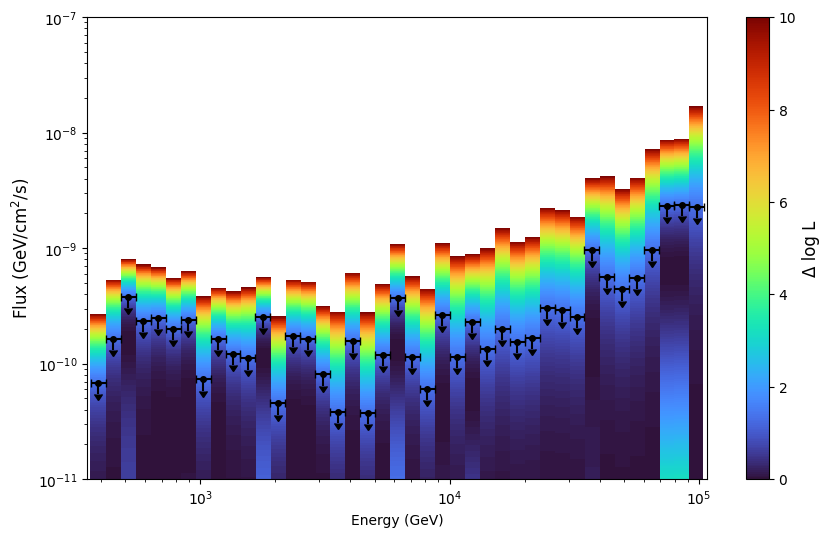

In [263]:
plot_likelihood_energy(ll_array, energyflux)